In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import sbi.utils as utils
from sbi.inference import infer

In [2]:
N_POP = 4
N_SIMU = 200

In [5]:
H0 = torch.ones(N_POP) * 100

thresh1 = torch.ones(N_POP) * 0.1
thresh2 = torch.ones(N_POP * N_POP) * 1e-4

prior = utils.BoxUniform(low=torch.zeros(N_POP + N_POP * N_POP), high=torch.cat([thresh1, thresh2]))

In [8]:
def f(x, r, A):
    return r + A @ x


def simulator(theta):
    r = theta[:N_POP]
    A = theta[N_POP:].reshape(N_POP, N_POP)
    
    H = torch.zeros((H0.shape[0], N_SIMU+1))
    H[:, 0] = H0.clone()
    dt = 0.1
    
    for i in range(1, N_SIMU+1):
        H[:, i] = H[:, i-1] + dt * H[:, i-1] * f(H[:, i-1], r, A)
    
    return H[None, :, :]

In [9]:
observations = simulator(prior.sample())

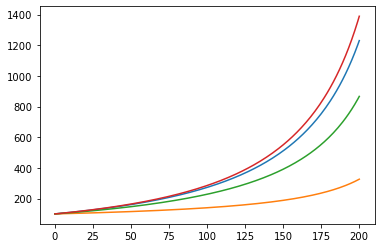

In [10]:
for i in range(N_POP):
    plt.plot(observations[0, i])
    
plt.show()

In [11]:
embedding = nn.Sequential(
    nn.Conv1d(N_POP, 16, kernel_size=5),
    nn.ReLU(),
    nn.Conv1d(16, 16, kernel_size=5),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(3088, 20)
)

In [12]:
embedding(observations)

tensor([[ 33.7300,  30.4259,  26.1243,  34.4203,   1.2095,  29.2331,  -1.1329,
         -12.6887,  22.6481,   3.8774, -23.7066,  -1.7593,   7.8392, -19.3743,
          -2.8268,   7.2129,  26.0651,  -5.5532,   2.3327,  -4.8362]],
       grad_fn=<AddmmBackward>)

In [13]:
from sbi import utils
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='maf', 
                                      embedding_net=embedding)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

# run the inference procedure on one round and 10000 simulated data points
theta_samples, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=5000)

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

In [14]:
density_estimator = inference.append_simulations(theta_samples, x).train()
posterior = inference.build_posterior(density_estimator)

Neural network successfully converged after 133 epochs.


In [15]:
theta_samples.shape

torch.Size([5000, 20])

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

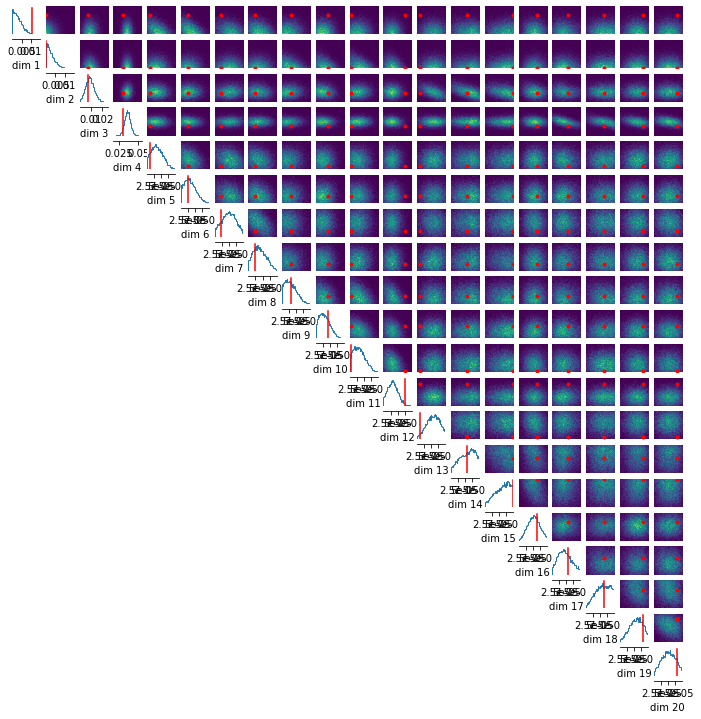

In [19]:
theta = prior.sample()

observation = simulator(theta)
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = utils.pairplot(samples,
                #    limits=[[0,0.5],[0,1e-4],[0,0.5], [0, 2e-4]],
                   points=theta,
                   points_offdiag={'markersize': 6},
                   points_colors='r',
                   fig_size=(12,12))